<a href="https://colab.research.google.com/github/zhongjie-wu/579project/blob/main/DQN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install pettingzoo
# !pip install pygame

In [21]:
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten
from pettingzoo.mpe import simple_speaker_listener_v3, simple_reference_v2, simple_world_comm_v2
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm
import os
import json
from sklearn.preprocessing import StandardScaler
from DQNAgent import *

In [22]:
def eps_greedy_act_selection(epsilon, action_space_size, q_values):
    if np.random.random() < epsilon:
        # randomly choose one action
        return np.random.randint(0, action_space_size)
    else:
        # all q values
        return np.argmax(q_values)

def normalization(X):
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)
    
        # Normalize the features using the mean and standard deviation
        X_norm = (X - mu) / sigma

        return X_norm

In [ ]:
class DQNAgent:
    def __init__(self, input_layer_size, action_space_size):
        # Main model which we use to train
        self.model = self.create_model(input_layer_size, action_space_size)

        # Target network to make sure the updating is stable
        self.target_model = self.create_model(input_layer_size, action_space_size)
        self.target_model.set_weights(self.model.get_weights())

        # The array to keep the memory for the last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Count when to update target network with main network's weights
        self.target_update_counter = 0


    def create_model(self, input_layer_size, action_space_size):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(input_layer_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(action_space_size, activation = 'linear'))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        # transition = (s, a, r, s', done)
        self.replay_memory.append(transition)


    def train(self, terminal_state):
        # Start training only if enough transition samples has been collected in the memory
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get the current states and their corresponding q values for each sample in the minibatch
        current_states = np.array([transition[0] for transition in minibatch])
        # current_states = StandardScaler().fit_transform(current_states)
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Get the next states their corresponding q values for each sample in the minibatch
        new_current_states = np.array([transition[3] for transition in minibatch])
        # new_current_states = StandardScaler().fit_transform(new_current_states)
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        y = []

        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward
            
            # Update Q value for the given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # Prepare training data
            X.append(current_state)
            y.append(current_qs)

            # Perform normalization on X
            # X = StandardScaler().fit_transform(np.array(X))

        self.model.fit(np.array(X), np.array(y), shuffle=False, verbose=0)

        if terminal_state:
            self.target_update_counter += 1
        
        # update target network with weights of main network if condition satisfied
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)[0]

In [23]:
AGENT_NAMES = ['speaker_0', 'listener_0']
AGENT_INFOS = {
    name:
        {
            "state_space_size": 3 if name == 'speaker_0' else 11, 
            "action_space_size": 3 if name == 'speaker_0' else 5 
        } for name in AGENT_NAMES
}

def dqn_sl(epsilon, num_episode, max_cycles, env):    
    # initialize DQNAgents for the listener / speaker
    all_dqn_agents = {name: DQNAgent(AGENT_INFOS[name]["state_space_size"], 
                                     AGENT_INFOS[name]["action_space_size"]) for name in AGENT_NAMES}
    
    all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
    
    for episode in tqdm(range(1, num_episode + 1), ascii=True, unit='episodes'):
    # for episode in range(num_episode):
        # initialize environment & reward
        env.reset()
        episode_agent_reward = {agent_name:0 for agent_name in AGENT_NAMES}
        
        for agent in env.agent_iter():
            # do not do step if terminated 
            if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue    
            # storing size of action and state (metadata about agent)
            agent_info = AGENT_INFOS[agent]
            # store the corresponding dqn agent (not the game agent, the agent that does dqn stuff)
            dqn_agent = all_dqn_agents[agent]
            # actual agent living in environment
            game_agent_cur_state = env.observe(agent)
            
            game_agent_q_val = dqn_agent.get_qs(game_agent_cur_state)
            game_agent_action_size = agent_info["action_space_size"]
            action_taken = eps_greedy_act_selection(epsilon, game_agent_action_size, game_agent_q_val)
            
            # take the action choosen from eps greedy
            env.step(action_taken)
            
            # get reward and accumulate it
            _, R, termination, truncation, info = env.last()
            done = termination or truncation
            episode_agent_reward[agent] += R
            
            # get next state S'
            game_agent_next_state = env.observe(agent)
            
            # update replay memory, and train if we have enough replay memory
            dqn_agent.update_replay_memory((game_agent_cur_state, action_taken, R, game_agent_next_state, done))
            dqn_agent.train(done)
        
        # store the total rewards for last game play in one episode
        for name in AGENT_NAMES:
            all_rewards[name].append(episode_agent_reward[name]/max_cycles)
        
        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY
            epsilon = max(MIN_EPSILON, epsilon)
             
    return all_rewards

In [24]:
# Returns a initialized weight vector with 0
def rand_sl(num_episode, max_cycles,  env):
    
    
    all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
    
    for i in range(num_episode):
        env.reset()
        episode_agent_reward = {agent_name:0 for agent_name in AGENT_NAMES}
        for agent in env.agent_iter():
            if env.truncations[agent] == True or env.terminations[agent] == True:
                env.step(None)
                continue
            
            A = env.action_space(agent).sample()

            env.step(A)
            _, R, termination, truncation, info = env.last()
            episode_agent_reward[agent] += R

            if termination or truncation:
                continue
            
        # store the total rewards for last game play in one episode
        for name in AGENT_NAMES:
            all_rewards[name].append(episode_agent_reward[name]/max_cycles)
    return all_rewards

100%|##########| 1000/1000 [1:35:15<00:00,  5.72s/episodes]


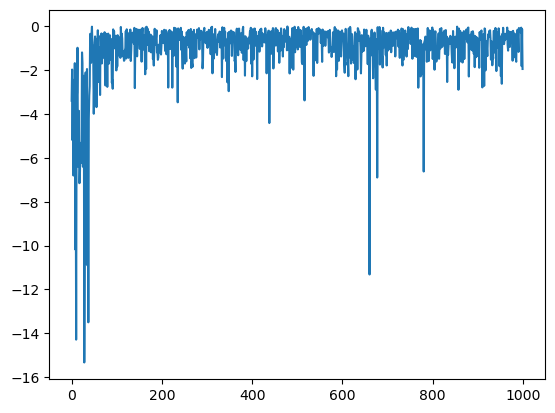

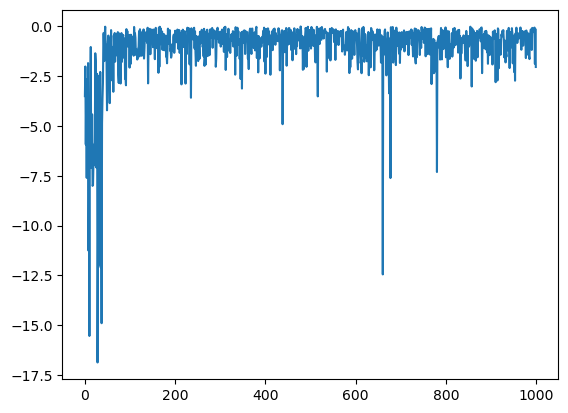

In [25]:
# run and plot dqn data
env = simple_speaker_listener_v3.env(max_cycles=MAX_CYCLES, continuous_actions=False)
R = dqn_sl(EPSILON, EPISODES, MAX_CYCLES, env)

with open(f"dqn_data_ep{EPISODES}_cycles_{MAX_CYCLES}.json", "w") as f:
    # store the experiement result
    json.dump(R, f)

plt.plot(range(EPISODES), R['speaker_0'])
plt.show()

plt.plot(range(EPISODES), R['listener_0'])
plt.show()

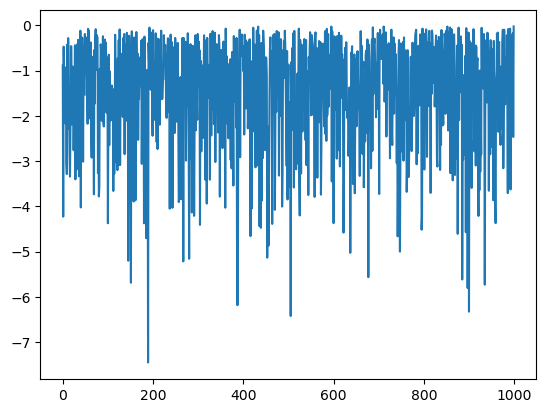

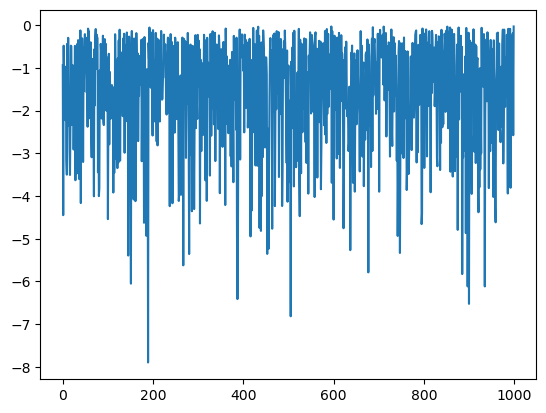

In [26]:
# Run and plot random experiment
env = simple_speaker_listener_v3.env(max_cycles=MAX_CYCLES, continuous_actions=False)
R_rand = rand_sl(EPISODES, MAX_CYCLES, env)
plt.plot(range(EPISODES), R_rand['speaker_0'])
plt.show()

plt.plot(range(EPISODES), R_rand['listener_0'])
plt.show()